# 毕业项目：检测分神司机

In [2]:
%config InlineBackend.figure_format = 'retina'

from urllib.request import urlretrieve
from os.path import isfile, isdir, join, pardir
from IPython.display import SVG, Image
import os, shutil
import random
import glob
import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras import optimizers
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.utils import to_categorical
from keras import regularizers

from keras.applications import inception_v3
from keras.applications.inception_v3 import InceptionV3


import pydot
import cv2
import h5py

d:\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
driver_dataset_folder_path = join(pardir, 'data', 'driver_dataset')
image_train_folder_path = join(pardir, 'data', 'driver_dataset', 'train')
image_test_floder_path = join(pardir, 'data', 'driver_dataset', 'test')
image_valid_folder_path = join(pardir, 'data', 'driver_dataset', 'valid')

inceptionv3_train_datagen = ImageDataGenerator(
    rotation_range=10.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    preprocessing_function=inception_v3.preprocess_input)

inceptionv3_valid_datagen = ImageDataGenerator(
    preprocessing_function=inception_v3.preprocess_input)


inceptionv3_train_generator = inceptionv3_train_datagen.flow_from_directory(
    image_train_folder_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical')

inceptionv3_valid_generator = inceptionv3_valid_datagen.flow_from_directory(
    image_valid_folder_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

d:\python35\lib\site-packages\keras\preprocessing\image.py:504: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 20097 images belonging to 10 classes.
Found 2327 images belonging to 10 classes.


### 二、创建模型

In [8]:
model_inceptionv3 = InceptionV3(include_top=False, weights='imagenet')

#print('Print resnet50 model summary:')
#print(model_resnet50.summary())

for i, layer in enumerate(model_inceptionv3.layers):
    print (i, layer.name)
        
input = Input(shape=(299, 299, 3),name = 'image_input')
 
output_inceptionv3_conv = model_inceptionv3(input)
   
x = GlobalAveragePooling2D()(output_inceptionv3_conv)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(x)

0 input_3
1 conv2d_189
2 batch_normalization_189
3 activation_189
4 conv2d_190
5 batch_normalization_190
6 activation_190
7 conv2d_191
8 batch_normalization_191
9 activation_191
10 max_pooling2d_9
11 conv2d_192
12 batch_normalization_192
13 activation_192
14 conv2d_193
15 batch_normalization_193
16 activation_193
17 max_pooling2d_10
18 conv2d_197
19 batch_normalization_197
20 activation_197
21 conv2d_195
22 conv2d_198
23 batch_normalization_195
24 batch_normalization_198
25 activation_195
26 activation_198
27 average_pooling2d_19
28 conv2d_194
29 conv2d_196
30 conv2d_199
31 conv2d_200
32 batch_normalization_194
33 batch_normalization_196
34 batch_normalization_199
35 batch_normalization_200
36 activation_194
37 activation_196
38 activation_199
39 activation_200
40 mixed0
41 conv2d_204
42 batch_normalization_204
43 activation_204
44 conv2d_202
45 conv2d_205
46 batch_normalization_202
47 batch_normalization_205
48 activation_202
49 activation_205
50 average_pooling2d_20
51 conv2d_201
52 

### 三、模型创建
#### 1.锁定ResNet50模型前100层

In [7]:
model_100 = Model(input=input, output=x)

for i in range(100):
    model_inceptionv3.layers[i].trainable = False
    
adam = optimizers.Adam(lr=1e-4)
model_100.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

d:\python35\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [8]:
history_100 = model_100.fit_generator(
    inceptionv3_train_generator,
    epochs=5,
    validation_data=inceptionv3_valid_generator)

Epoch 1/5


d:\python35\lib\site-packages\keras\preprocessing\image.py:571: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
d:\python35\lib\site-packages\keras\preprocessing\image.py:579: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


629/629 [==============================] - 467s 742ms/step - loss: 0.4471 - categorical_accuracy: 0.9200 - val_loss: 0.4534 - val_categorical_accuracy: 0.9265
Epoch 2/5
629/629 [==============================] - 457s 726ms/step - loss: 0.1785 - categorical_accuracy: 0.9902 - val_loss: 0.4180 - val_categorical_accuracy: 0.9239
Epoch 3/5
629/629 [==============================] - 456s 724ms/step - loss: 0.1238 - categorical_accuracy: 0.9936 - val_loss: 0.4117 - val_categorical_accuracy: 0.9145
Epoch 4/5
629/629 [==============================] - 456s 725ms/step - loss: 0.0874 - categorical_accuracy: 0.9942 - val_loss: 0.3990 - val_categorical_accuracy: 0.9102
Epoch 5/5
629/629 [==============================] - 458s 728ms/step - loss: 0.0623 - categorical_accuracy: 0.9957 - val_loss: 0.3970 - val_categorical_accuracy: 0.9046


In [9]:
model_100.save(join(pardir, 'model', 'inceptionv3_finetune_100.h5'))
print("Inceptionv3 model saved.")

d:\python35\lib\site-packages\keras\preprocessing\image.py:571: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
d:\python35\lib\site-packages\keras\preprocessing\image.py:579: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Inceptionv3 model saved.


{'val_loss': [0.45337795191790653, 0.4180121127248681, 0.4116594876964358, 0.39898851776409927, 0.3970207563018307], 'val_categorical_accuracy': [0.9265148260842386, 0.9239363989248058, 0.9144821657251276, 0.9101847872285306, 0.9045981950497597], 'loss': [0.4438318363936996, 0.17472542808643945, 0.12058071526163294, 0.0840852961300819, 0.05842305290916698], 'categorical_accuracy': [0.9213813006916455, 0.9916903020351296, 0.9951236502960641, 0.9957705130118923, 0.9972135144548938]}


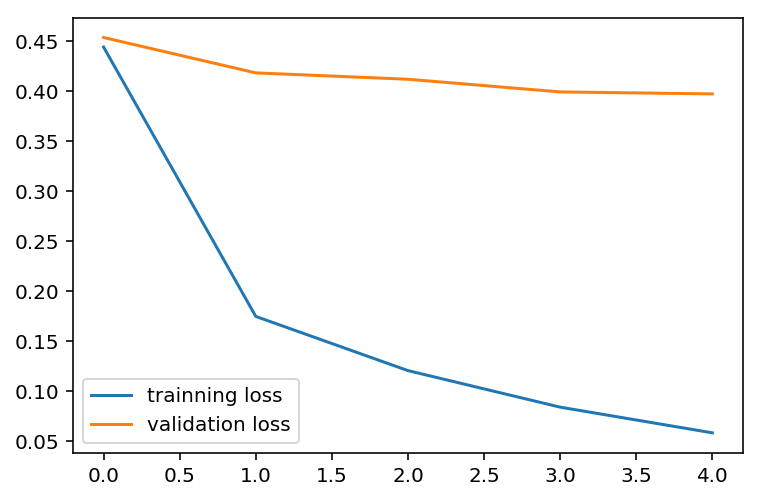

In [10]:
print (history_100.history)
plt.plot (history_100.history['loss'], label="trainning loss")
plt.plot (history_100.history['val_loss'], label="validation loss")
plt.legend()
plt.show()

#### 2.锁定InceptionV3模型前196层

In [11]:
model_196 = Model(input=input, output=x)

for i in range(196):
    model_inceptionv3.layers[i].trainable = False
    
adam = optimizers.Adam(lr=1e-4)
model_196.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

d:\python35\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("im...)`
  """Entry point for launching an IPython kernel.


In [12]:
history_196 = model_196.fit_generator(
    inceptionv3_train_generator,
    epochs=5,
    validation_data=inceptionv3_valid_generator)

Epoch 1/5


d:\python35\lib\site-packages\keras\preprocessing\image.py:571: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
d:\python35\lib\site-packages\keras\preprocessing\image.py:579: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


629/629 [==============================] - 468s 744ms/step - loss: 0.0442 - categorical_accuracy: 0.9971 - val_loss: 0.4300 - val_categorical_accuracy: 0.9192
Epoch 2/5
629/629 [==============================] - 683s 1s/step - loss: 0.0308 - categorical_accuracy: 0.9973 - val_loss: 0.3592 - val_categorical_accuracy: 0.9158
Epoch 3/5
629/629 [==============================] - 690s 1s/step - loss: 0.0277 - categorical_accuracy: 0.9974 - val_loss: 0.3997 - val_categorical_accuracy: 0.9093
Epoch 4/5
629/629 [==============================] - 452s 719ms/step - loss: 0.0274 - categorical_accuracy: 0.9986 - val_loss: 0.3236 - val_categorical_accuracy: 0.9179
Epoch 5/5
629/629 [==============================] - 451s 718ms/step - loss: 0.0254 - categorical_accuracy: 0.9975 - val_loss: 0.4370 - val_categorical_accuracy: 0.9132


In [13]:
model_196.save(join(pardir, 'model', 'inceptionv3_finetune_196.h5'))
print("InceptionV3 model saved.")

d:\python35\lib\site-packages\keras\preprocessing\image.py:571: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
d:\python35\lib\site-packages\keras\preprocessing\image.py:579: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


InceptionV3 model saved.


{'val_loss': [0.43004352100222315, 0.3592001073699577, 0.39971152417998895, 0.3236239800957277, 0.4370423220210082], 'val_categorical_accuracy': [0.9192092823633883, 0.9157713794073016, 0.9093253114190694, 0.9179200686043714, 0.913192952260676], 'loss': [0.04131051465730296, 0.02753687141878472, 0.02432185079278285, 0.02419825597219149, 0.021859642222205603], 'categorical_accuracy': [0.9970642384435487, 0.9988555505796886, 0.9989053092501369, 0.9986067572274469, 0.9990545852614818]}


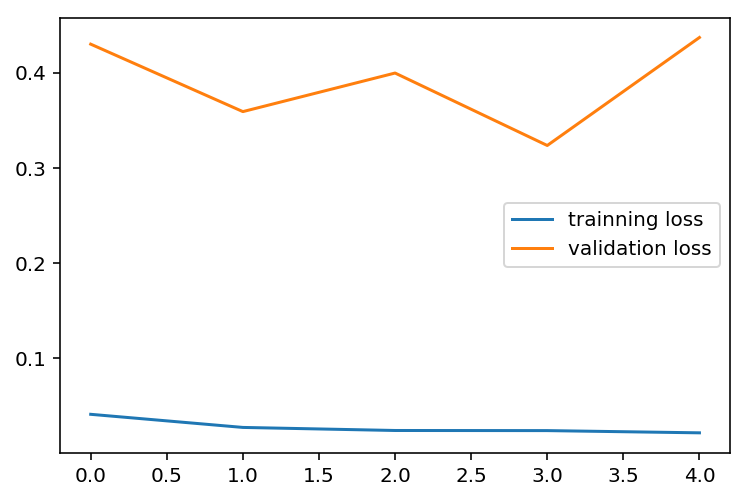

In [14]:
print (history_196.history)
plt.plot (history_196.history['loss'], label="trainning loss")
plt.plot (history_196.history['val_loss'], label="validation loss")
plt.legend()
plt.show()

### 四、模型预测
准备测试集数据

In [15]:
test_image_path = join(driver_dataset_folder_path, 'test')
incpetionv3_test_datagen = ImageDataGenerator(preprocessing_function=inception_v3.preprocess_input)
incpetionv3_test_generator = incpetionv3_test_datagen.flow_from_directory(
    test_image_path,
    target_size=(299, 299),
    batch_size=32,
    shuffle=False,
    class_mode='categorical')

Found 79726 images belonging to 1 classes.


#### 1.model_InceptionV3_finetune_100
模型加载

In [16]:
model_inceptionv3_finetune_100 = load_model(join(pardir, 'model', 'inceptionv3_finetune_100.h5'))
print("Model loaded.")

Model loaded.


结果预测

In [17]:
pred_inceptionv3_finetune_100 = model_inceptionv3_finetune_100.predict_generator(incpetionv3_test_generator, verbose=1)
print(pred_inceptionv3_finetune_100.shape)

2492/2492 [==============================] - 790s 317ms/step
(79726, 10)


生成kaggle提交文件

In [18]:
image_names = []
for root, dirs, file_name in os.walk(join(test_image_path, '0')):
    image_names.append(file_name)
image_names = np.array(image_names).transpose()

In [26]:
result_inceptionv3_finetune_100 = np.append(image_names, pred_inceptionv3_finetune_100, axis = 1)
predict_result_inceptionv3_finetune_100 = pd.DataFrame(result_inceptionv3_finetune_100, 
            columns=['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
predict_result_inceptionv3_finetune_100.to_csv('result_inceptionv3_finetune_100.csv', index=False)

#### 2.model_InceptionV3_finetune_196
模型加载

In [20]:
model_inceptionv3_finetune_196 = load_model(join(pardir, 'model', 'inceptionv3_finetune_196.h5'))
print("Model loaded.")

Model loaded.


结果预测

In [21]:
pred_inceptionv3_finetune_196 = model_inceptionv3_finetune_100.predict_generator(incpetionv3_test_generator, verbose=1)
print(pred_inceptionv3_finetune_196.shape)

2492/2492 [==============================] - 791s 318ms/step
(79726, 10)


生成kaggle提交文件

In [22]:
image_names = []
for root, dirs, file_name in os.walk(join(test_image_path, '0')):
    image_names.append(file_name)
image_names = np.array(image_names).transpose()

In [27]:
result_inceptionv3_finetune_196 = np.append(image_names, pred_inceptionv3_finetune_196, axis = 1)
predict_result_inceptionv3_finetune_196 = pd.DataFrame(result_inceptionv3_finetune_196, 
            columns=['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
predict_result_inceptionv3_finetune_196.to_csv('result_inceptionv3_finetune_196.csv', index=False)